In [209]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_chess_games(base_url, num_pages):
    all_data = []

    for page in range(1, num_pages + 1):
        url = base_url.format(page)
        response = requests.get(url)

        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as errh:
            print("HTTP Error:", errh)
            continue
        except requests.exceptions.ConnectionError as errc:
            print("Error Connecting:", errc)
            continue
        except requests.exceptions.Timeout as errt:
            print("Timeout Error:", errt)
            continue
        except requests.exceptions.RequestException as err:
            print("Error:", err)
            continue

        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', class_='table-component')

        if table:
            rows = table.find('tbody').find_all('tr')
            for row in rows:
                players = [player.text.strip() for player in row.find_all('a', class_='user-username-component')]

                result_cells = row.find('div', class_='archive-games-result-wrapper-score')
                result_divs = result_cells.find_all('div')
                results = [result_div.text.strip() for result_div in result_divs]
                result = results if (result_cells and len(results) == 2) else 'Result not available'

                accuracy_cells = row.find_all('td', class_='table-text-center archive-games-analyze-cell')
                accuracy_divs = accuracy_cells[0].find_all('div')
                accuracies = [float(accuracy_div.text.strip()) for accuracy_div in accuracy_divs]
                accuracy = accuracies if (accuracy_cells and len(accuracies) == 2) else [None, None]

                elo_cells = row.find_all('span', class_='user-tagline-rating')
                elos = [int(elo.text.strip('()')) for elo in elo_cells]
                elo = elos if len(elos) == 2 else [None, None]

                color_span = row.find_all('span', class_='archive-games-color-play-icon')
                color_class1 = color_span[0].get('class') if color_span else []
                color_class2 = color_span[1].get('class') if color_span else []
                colors = ['White', 'Black']

                flags = row.find_all('div', {'data-cy': 'user-country-flag'})
                countries = [flag.get('v-tooltip', 'Country not available') for flag in flags]
                # Ensure the length of countries is at least 2
                countries.extend(['Country not available'] * (2 - len(countries)))

                type_of_game_span = row.find('span', class_='archive-games-game-time')
                type_of_game = type_of_game_span.text.strip() if type_of_game_span else 'Type of game not available'

                # Creating a list of dictionaries for each player
                game_data = [{'Moves': int(row.find_all('td', class_='table-text-center')[1].text.strip()),
                              'Date': row.find_all('td', class_='table-text-right')[0].text.strip(),
                              'Type_of_game': type_of_game,
                              'White_player': players[0],
                              'Result_white': result[0],
                              'Accuracy_white': accuracy[0],
                              'Elo_white': elo[0],
                              'Country_white': countries[0],
                              'Black_player': players[1] if len(players) > 1 else 'Player not available',
                              'Result_black': result[1] if len(result) > 1 else 'Result not available',
                              'Accuracy_black': accuracy[1] if len(accuracy) > 1 else 'Accuracy not available',
                              'Elo_black': elo[1],
                              'Country_black': countries[1]}
                             ]

                all_data.extend(game_data)

        time.sleep(5)

    return all_data


base_url = 'https://www.chess.com/games/archive/F3D3R1CK0?gameOwner=other_game&gameTypes%5B0%5D=chess960&gameTypes%5B1%5D=daily&gameType=live&page={}'
num_pages_to_scrape = 26  # Adjust this based on your requirements
chess_games_data = scrape_chess_games(base_url, num_pages_to_scrape)

# Convert the data to a DataFrame
df = pd.DataFrame(chess_games_data)

print(df)

      Moves          Date Type_of_game   White_player Result_white  \
0        29  Jan 19, 2024       10 min    aerryck2009            ½   
1        19  Jan 19, 2024       10 min       Valid1ty            0   
2        45  Jan 19, 2024       10 min      F3D3R1CK0            1   
3        17  Jan 19, 2024       10 min        vinzm93            1   
4        27  Jan 19, 2024       10 min      F3D3R1CK0            1   
...     ...           ...          ...            ...          ...   
1295     47  Jun 10, 2021       10 min        konj007            1   
1296     26  Jun 10, 2021       10 min   Nazgul_GLock            0   
1297     39  Jun 10, 2021       10 min      F3D3R1CK0            0   
1298     33  Jun 10, 2021       10 min    KaLLikRaThS            1   
1299     23  Jun 10, 2021       10 min  albert_wijaya            1   

      Accuracy_white  Elo_white       Country_white   Black_player  \
0               51.4        914             Denmark      F3D3R1CK0   
1               71.

In [210]:
df['Federico_white'] = (df['White_player'] == 'F3D3R1CK0').astype(int)

df.head(5)

,Moves,Date,Type_of_game,White_player,Result_white,Accuracy_white,Elo_white,Country_white,Black_player,Result_black,Accuracy_black,Elo_black,Country_black,Federico_white
0,29,"Jan 19, 2024",10 min,aerryck2009,½,51.4,914,Denmark,F3D3R1CK0,½,50.1,894,Italy,0
1,19,"Jan 19, 2024",10 min,Valid1ty,0,71.3,854,United States,F3D3R1CK0,1,83.9,893,Italy,0
2,45,"Jan 19, 2024",10 min,F3D3R1CK0,1,61.9,885,Italy,g80pedro,0,54.3,888,Switzerland,1
3,17,"Jan 19, 2024",10 min,vinzm93,1,NaN,959,France,F3D3R1CK0,0,NaN,877,Italy,0
4,27,"Jan 19, 2024",10 min,F3D3R1CK0,1,64.6,883,Italy,immortall0808,0,52.5,890,Poland,1


In [211]:
# Replace '1/2' with 0.5 in Result_White and Result_Black columns
df['Result_white'] = df['Result_white'].replace('½', 0.5)
df['Result_black'] = df['Result_black'].replace('½', 0.5)

# Convert the columns to numeric type
df['Result_white'] = pd.to_numeric(df['Result_white'])
df['Result_black'] = pd.to_numeric(df['Result_black'])

print("Unique values in 'Result_White':", df['Result_white'].unique())
print("Unique values in 'Result_Black':", df['Result_black'].unique())



Unique values in 'Result_White': [0.5 0.  1. ]
Unique values in 'Result_Black': [0.5 1.  0. ]


In [212]:
# Filter the DataFrame
df = df[df['Type_of_game'] == '10 min']

# Reset the index after filtering
df.reset_index(drop=True, inplace=True)
df.head(5)
print(df['Type_of_game'].unique())

['10 min']


In [213]:
# Create a new column for result values of Federico
df['Federico_result'] = df.apply(lambda row: row['Result_white'] if row['Federico_white'] == 1 else row['Result_black'], axis=1)
df.head(10)

,Moves,Date,Type_of_game,White_player,Result_white,Accuracy_white,Elo_white,Country_white,Black_player,Result_black,Accuracy_black,Elo_black,Country_black,Federico_white,Federico_result
0,29,"Jan 19, 2024",10 min,aerryck2009,0.5,51.4,914,Denmark,F3D3R1CK0,0.5,50.1,894,Italy,0,0.5
1,19,"Jan 19, 2024",10 min,Valid1ty,0.0,71.3,854,United States,F3D3R1CK0,1.0,83.9,893,Italy,0,1.0
2,45,"Jan 19, 2024",10 min,F3D3R1CK0,1.0,61.9,885,Italy,g80pedro,0.0,54.3,888,Switzerland,1,1.0
3,17,"Jan 19, 2024",10 min,vinzm93,1.0,NaN,959,France,F3D3R1CK0,0.0,NaN,877,Italy,0,0.0
4,27,"Jan 19, 2024",10 min,F3D3R1CK0,1.0,64.6,883,Italy,immortall0808,0.0,52.5,890,Poland,1,1.0
5,59,"Jan 18, 2024",10 min,F3D3R1CK0,1.0,83.9,874,Italy,Marvizcko,0.0,75.2,904,International,1,1.0
6,40,"Jan 18, 2024",10 min,Linguinifarfale,0.0,79.0,830,France,F3D3R1CK0,1.0,76.1,865,Italy,0,1.0
7,42,"Jan 18, 2024",10 min,PlutoniumApples,1.0,74.4,885,Netherlands,F3D3R1CK0,0.0,71.5,857,Italy,0,0.0
8,21,"Jan 18, 2024",10 min,Rebusalem,1.0,67.6,905,Norway,F3D3R1CK0,0.0,50.0,865,Italy,0,0.0
9,16,"Jan 18, 2024",10 min,F3D3R1CK0,1.0,66.3,872,Italy,ssssethhhh,0.0,73.3,802,United States,1,1.0


In [214]:
# Create 'Opponent_Result' based on 'Federico_Result'
df['Opponent_result'] = 1 - df['Federico_result'].astype(float)

print(df['Opponent_result'].unique())

[0.5 0.  1. ]


In [215]:
# Create 'Federico_Accuracy' and 'Opponent_Accuracy'
df['Federico_accuracy'] = df.apply(lambda row: row['Accuracy_white'] if row['Federico_white'] == 1 else row['Accuracy_black'], axis=1)
df['Opponent_accuracy'] = df.apply(lambda row: row['Accuracy_black'] if row['Federico_white'] == 1 else row['Accuracy_white'], axis=1)

# Create 'Federico_ELO' and 'Opponent_ELO'
df['Federico_ELO'] = df.apply(lambda row: row['Elo_white'] if row['Federico_white'] == 1 else row['Elo_black'], axis=1)
df['Opponent_ELO'] = df.apply(lambda row: row['Elo_black'] if row['Federico_white'] == 1 else row['Elo_white'], axis=1)

# Create 'opponent_country'
df['Opponent_country'] = df.apply(lambda row: row['Country_black'] if row['Federico_white'] == 1 else row['Country_white'], axis=1)

df.head(5)

,Moves,Date,Type_of_game,White_player,Result_white,Accuracy_white,Elo_white,Country_white,Black_player,Result_black,...,Elo_black,Country_black,Federico_white,Federico_result,Opponent_result,Federico_accuracy,Opponent_accuracy,Federico_ELO,Opponent_ELO,Opponent_country
0,29,"Jan 19, 2024",10 min,aerryck2009,0.5,51.4,914,Denmark,F3D3R1CK0,0.5,...,894,Italy,0,0.5,0.5,50.1,51.4,894,914,Denmark
1,19,"Jan 19, 2024",10 min,Valid1ty,0.0,71.3,854,United States,F3D3R1CK0,1.0,...,893,Italy,0,1.0,0.0,83.9,71.3,893,854,United States
2,45,"Jan 19, 2024",10 min,F3D3R1CK0,1.0,61.9,885,Italy,g80pedro,0.0,...,888,Switzerland,1,1.0,0.0,61.9,54.3,885,888,Switzerland
3,17,"Jan 19, 2024",10 min,vinzm93,1.0,NaN,959,France,F3D3R1CK0,0.0,...,877,Italy,0,0.0,1.0,NaN,NaN,877,959,France
4,27,"Jan 19, 2024",10 min,F3D3R1CK0,1.0,64.6,883,Italy,immortall0808,0.0,...,890,Poland,1,1.0,0.0,64.6,52.5,883,890,Poland


In [216]:
# Columns to drop
columns_to_drop = [
    'Type_of_game',
    'White_player', 'Black_player',
    'Result_white', 'Result_black',
    'Accuracy_white', 'Accuracy_black',
    'Elo_white', 'Elo_black',
    'Country_white', 'Country_black'
]

# Drop the columns
df = df.drop(columns=columns_to_drop)
df.head(5)

,Moves,Date,Federico_white,Federico_result,Opponent_result,Federico_accuracy,Opponent_accuracy,Federico_ELO,Opponent_ELO,Opponent_country
0,29,"Jan 19, 2024",0,0.5,0.5,50.1,51.4,894,914,Denmark
1,19,"Jan 19, 2024",0,1.0,0.0,83.9,71.3,893,854,United States
2,45,"Jan 19, 2024",1,1.0,0.0,61.9,54.3,885,888,Switzerland
3,17,"Jan 19, 2024",0,0.0,1.0,NaN,NaN,877,959,France
4,27,"Jan 19, 2024",1,1.0,0.0,64.6,52.5,883,890,Poland


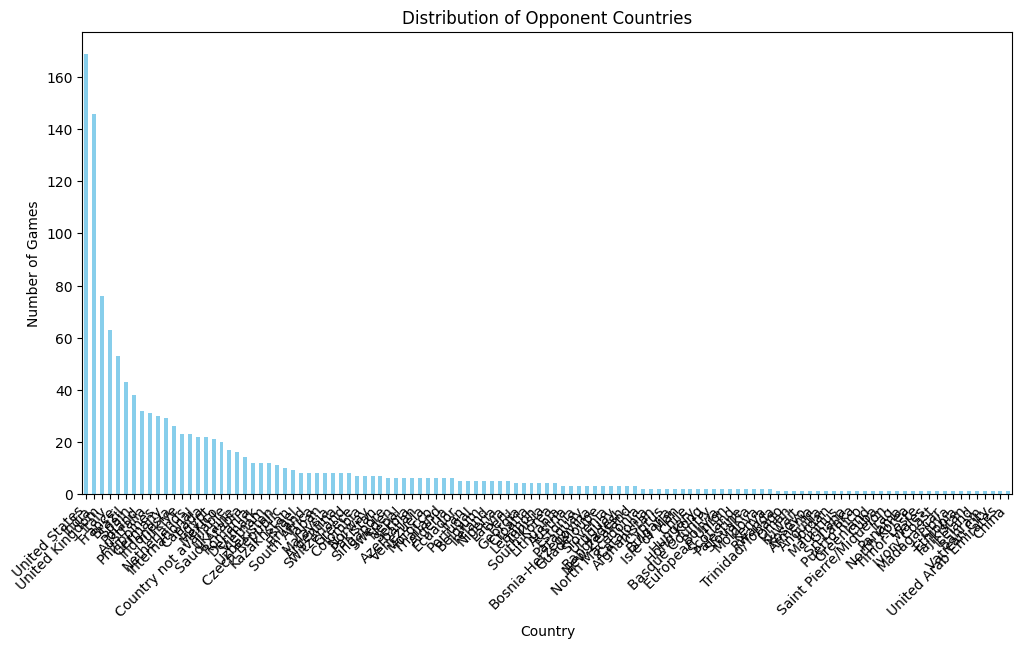

In [217]:
import matplotlib.pyplot as plt

opponent_countries_counts = df['Opponent_country'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(12, 6))
opponent_countries_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Opponent Countries')
plt.xlabel('Country')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

C:\Users\Mr.Beast\AppData\Local\Temp\ipykernel_14532\3779032256.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(opponent_countries_counts_filtered.index, rotation=45, ha='right', rotation_mode="anchor")


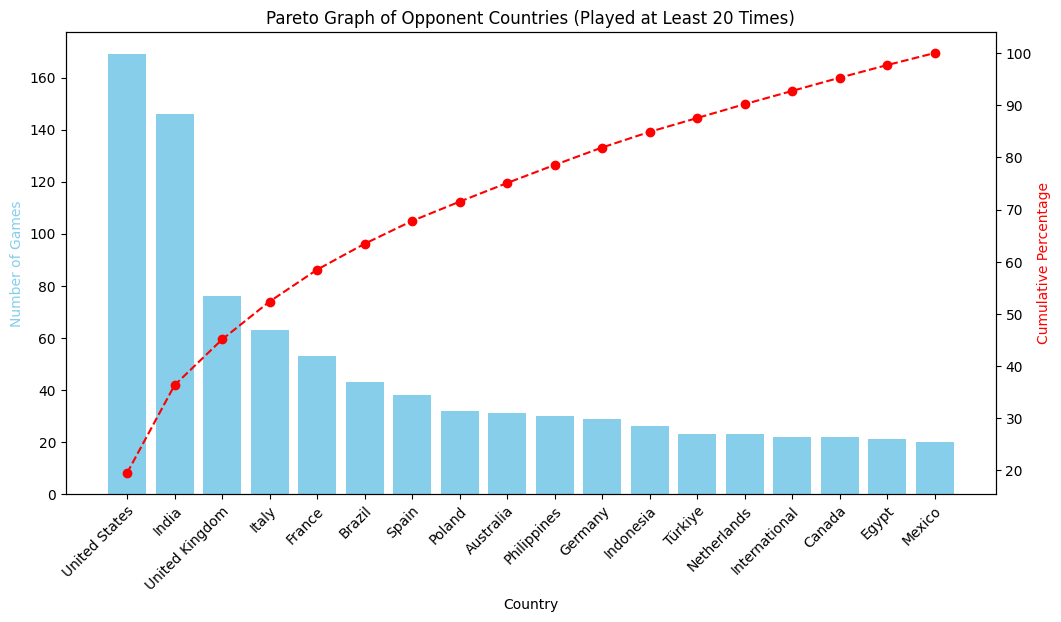

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame and 'Opponent_country' column
# Create a Series with the counts of each opponent country
opponent_countries_counts = df['Opponent_country'].value_counts()

# Filter for countries played at least 20 times
opponent_countries_counts_filtered = opponent_countries_counts[opponent_countries_counts >= 20]

# Calculate cumulative percentage
cumulative_percentage = (opponent_countries_counts_filtered.cumsum() / opponent_countries_counts_filtered.sum()) * 100

# Plotting the bar graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar graph
ax1.bar(opponent_countries_counts_filtered.index, opponent_countries_counts_filtered, color='skyblue')

# Line plot for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(opponent_countries_counts_filtered.index, cumulative_percentage, color='red', marker='o', linestyle='--')

# Setting labels and title
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Games', color='skyblue')
ax2.set_ylabel('Cumulative Percentage', color='red')
plt.title('Pareto Graph of Opponent Countries (Played at Least 20 Times)')

# Explicitly set rotation for x-axis labels
ax1.set_xticklabels(opponent_countries_counts_filtered.index, rotation=45, ha='right', rotation_mode="anchor")

# Show the plot
plt.show()


                  Win/Loss Ratio
Opponent_country                
United States               1.07
India                       0.93
United Kingdom              1.09
Italy                       1.27
France                      1.30
Brazil                      0.62
Spain                       1.06
Poland                      1.21
Australia                   1.23
Philippines                 0.75
Germany                     1.08
Indonesia                   0.86
Netherlands                 2.00
Türkiye                     1.44
International               1.20
Canada                      0.38
Egypt                       2.00
Mexico                      1.50


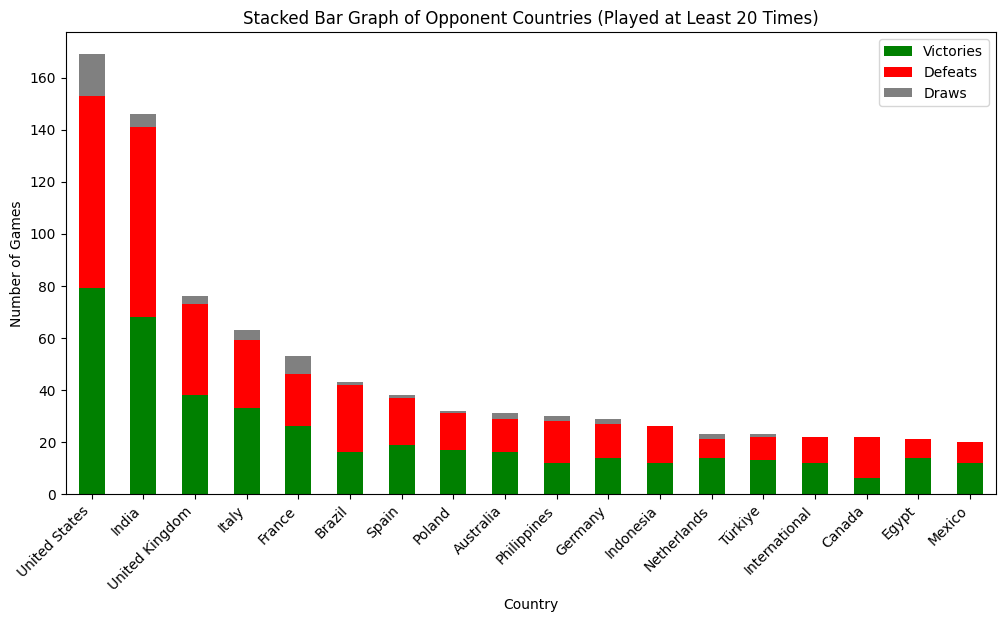

In [219]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame and relevant columns
# For example: 'Opponent_country', 'Federico_Result', and 'Opponent_result'

# Filter for countries played at least 20 times
opponent_countries_counts_filtered = opponent_countries_counts[opponent_countries_counts >= 20]

# Create a DataFrame with relevant columns for each country
stacked_df = pd.DataFrame({
    'Victories': df[df['Opponent_country'].isin(opponent_countries_counts_filtered.index) & (df['Federico_result'] == 1)].groupby('Opponent_country').size(),
    'Defeats': df[df['Opponent_country'].isin(opponent_countries_counts_filtered.index) & (df['Federico_result'] == 0)].groupby('Opponent_country').size(),
    'Draws': df[df['Opponent_country'].isin(opponent_countries_counts_filtered.index) & (df['Federico_result'] == 0.5)].groupby('Opponent_country').size()
}).fillna(0)

# Calculate the total number of games for each country and sort by it
stacked_df['Total'] = stacked_df.sum(axis=1)
stacked_df = stacked_df.sort_values(by='Total', ascending=False)

# Calculate the ratio of wins to losses for each country
stacked_df['Win/Loss Ratio'] = stacked_df['Victories'] / stacked_df['Defeats']

# Create a stacked bar graph
stacked_df.drop(['Total', 'Win/Loss Ratio'], axis=1).plot(kind='bar', stacked=True, color=['green', 'red', 'grey'], figsize=(12, 6))

# Setting labels and title
plt.xlabel('Country')
plt.ylabel('Number of Games')
plt.title('Stacked Bar Graph of Opponent Countries (Played at Least 20 Times)')

# Explicitly set rotation for x-axis labels
plt.xticks(rotation=45, ha='right')

# Print the Win/Loss Ratio for each country
print(round(stacked_df[['Win/Loss Ratio']], 2))

# Show the plot
plt.show()


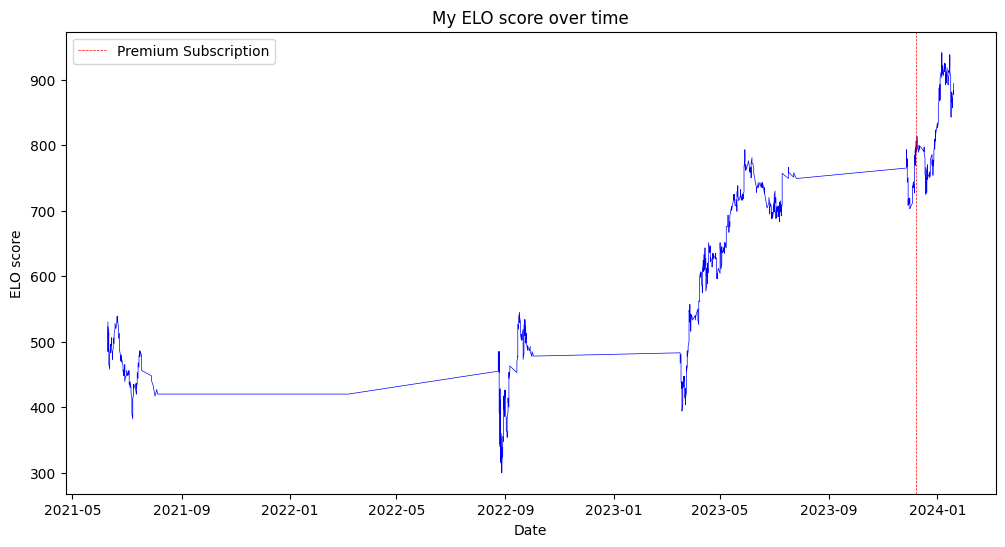

In [220]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Plotting the trend of Federico_ELO over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Federico_ELO'], marker='o', linestyle='-', color='blue', linewidth=0.5, markersize=0)

# Adding a vertical line on December 08th
subscription_date = datetime(2023, 12, 8)
plt.axvline(x=subscription_date, color='red', linestyle='--', linewidth=0.5, markersize=0, label='Premium Subscription')

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('ELO score')
plt.title('My ELO score over time')
plt.legend()

# Show the plot
plt.show()



In [221]:
# Assuming your DataFrame is already reversed
df['Rank'] = range(len(df), 0, -1)

# Display the DataFrame with the new "Rank" column
print(df[['Date', 'Federico_ELO', 'Rank']])

           Date  Federico_ELO  Rank
0    2024-01-19           894  1271
1    2024-01-19           893  1270
2    2024-01-19           885  1269
3    2024-01-19           877  1268
4    2024-01-19           883  1267
...         ...           ...   ...
1266 2021-06-10           495     5
1267 2021-06-10           509     4
1268 2021-06-10           496     3
1269 2021-06-10           511     2
1270 2021-06-10           530     1

[1271 rows x 3 columns]


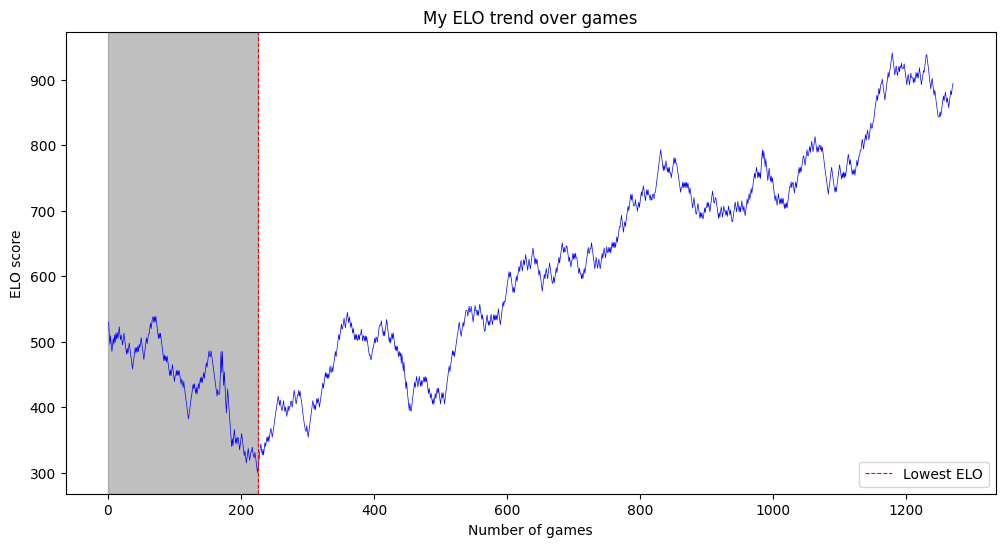

In [222]:
# Find the rank of Dec 8th, 2023
rank_dec_8_2023 = df[df['Date'] == 'Dec 8, 2023']['Rank'].values[0]

# Find the rank of the game with the lowest Federico_ELO
lowest_elo_rank = df[df['Federico_ELO'] == df['Federico_ELO'].min()]['Rank'].values[0]

import matplotlib.pyplot as plt

# Reverse the DataFrame for chronological order
df = df[::-1]

# Plotting the trend of Federico_ELO over games for the specified ranks
plt.figure(figsize=(12, 6))
plt.plot(df['Rank'], df['Federico_ELO'], marker='o', linestyle='-', color='blue', linewidth=0.5, markersize=0)

# Adding a vertical red line at rank 1080
plt.axvline(x=lowest_elo_rank, color='red', linestyle='--', linewidth=0.8, label='Lowest ELO')

plt.axvspan(0, lowest_elo_rank, color='grey', alpha=0.5)

# Setting labels and title
plt.xlabel('Number of games')
plt.ylabel('ELO score')
plt.title('My ELO trend over games')

# Adding legend
plt.legend()

# Show the plot
plt.show()



In [223]:
# Filter the DataFrame to keep only games with a rank greater than or equal to 236
df = df[df['Rank'] >= lowest_elo_rank]

# Re-rank the remaining games starting from 1
df['Rank'] = range(1, len(df) + 1)
df.head(5)

,Moves,Date,Federico_white,Federico_result,Opponent_result,Federico_accuracy,Opponent_accuracy,Federico_ELO,Opponent_ELO,Opponent_country,Rank
1046,32,2022-08-28,1,0.0,1.0,NaN,NaN,300,359,United States,1
1045,83,2022-08-28,0,1.0,0.0,61.1,59.4,309,326,United States,2
1044,12,2022-08-28,1,1.0,0.0,NaN,NaN,319,374,Netherlands,3
1043,26,2022-08-29,0,1.0,0.0,NaN,NaN,328,180,Kazakhstan,4
1042,32,2022-08-29,1,1.0,0.0,85.1,73.2,338,406,Brazil,5


In [224]:
# Filter the DataFrame for games played during December 8 and 9, 2023
dec_games = df[(df['Date'] == 'Dec 8, 2023') ]

# Print the number of games played during December 8 and 9, 2023
print("Number of games played during December 8, 2023:", len(dec_games))

Number of games played during December 8, 2023: 6


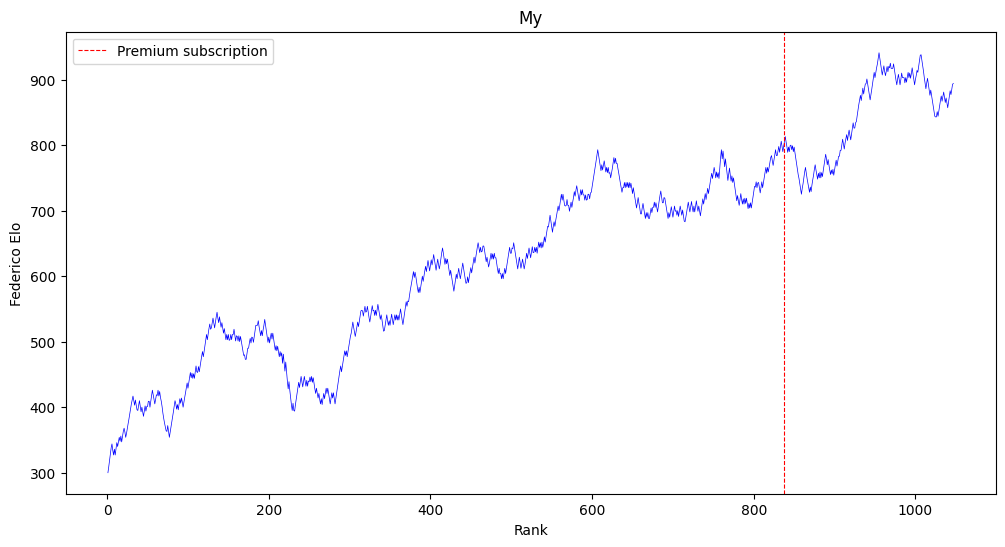

In [225]:
# Find the rank of Dec 8th, 2023
rank_dec_8_2023 = df[df['Date'] == 'Dec 8, 2023']['Rank'].values[0]

# Find the rank of the game with the lowest Federico_ELO
lowest_elo_rank = df[df['Federico_ELO'] == df['Federico_ELO'].min()]['Rank'].values[0]

import matplotlib.pyplot as plt

# Reverse the DataFrame for chronological order
df = df[::-1]

# Plotting the trend of Federico_ELO over games for the specified ranks
plt.figure(figsize=(12, 6))
plt.plot(df['Rank'], df['Federico_ELO'], marker='o', linestyle='-', color='blue', linewidth=0.5, markersize=0)

# Adding a vertical red line at membership
plt.axvline(x=rank_dec_8_2023 + 6, color='red', linestyle='--', linewidth=0.8, label='Premium subscription')

# Setting labels and title
plt.xlabel('Rank')
plt.ylabel('Federico Elo')
plt.title('My')

# Adding legend
plt.legend()

# Show the plot
plt.show()


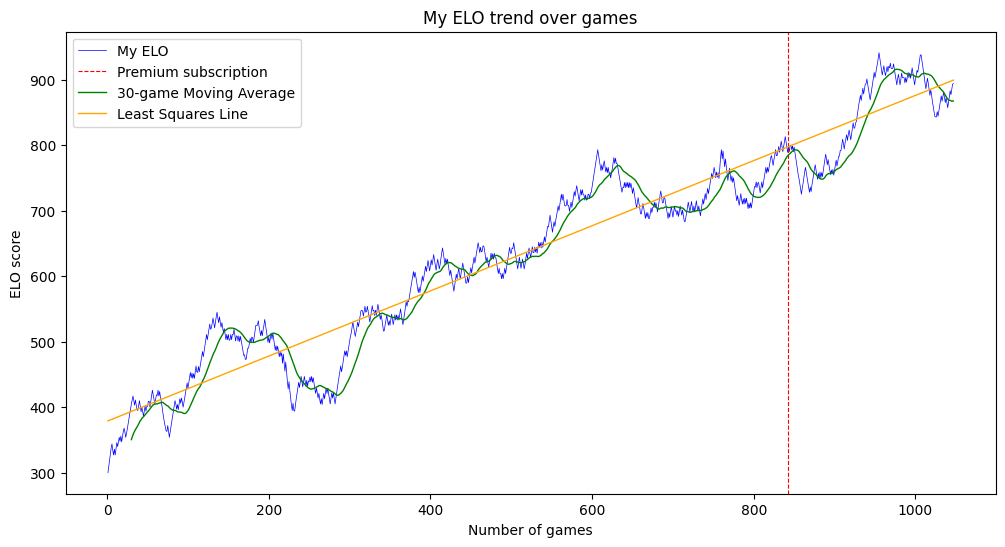

In [226]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse the DataFrame for chronological order
df = df[::-1]

# Plotting the trend of Federico_ELO over games for the specified ranks
plt.figure(figsize=(12, 6))
plt.plot(df['Rank'], df['Federico_ELO'], marker='o', linestyle='-', color='blue', linewidth=0.5, markersize=0, label='My ELO')

# Adding a vertical red line at membership
plt.axvline(x=rank_dec_8_2023 + 11, color='red', linestyle='--', linewidth=0.8, label='Premium subscription')

# Adding a 30-game moving average line
rolling_avg = df['Federico_ELO'].rolling(window=30).mean()
plt.plot(df['Rank'], rolling_avg, color='green', linestyle='-', linewidth=1, label='30-game Moving Average')

# Adding a least squares line
fit = np.polyfit(df['Rank'], df['Federico_ELO'], 1)
least_squares_line = np.polyval(fit, df['Rank'])
plt.plot(df['Rank'], least_squares_line, color='orange', linestyle='-', linewidth=1, label='Least Squares Line')

# Setting labels and title
plt.xlabel('Number of games')
plt.ylabel('ELO score')
plt.title('My ELO trend over games')

# Adding legend
plt.legend()

# Show the plot
plt.show()


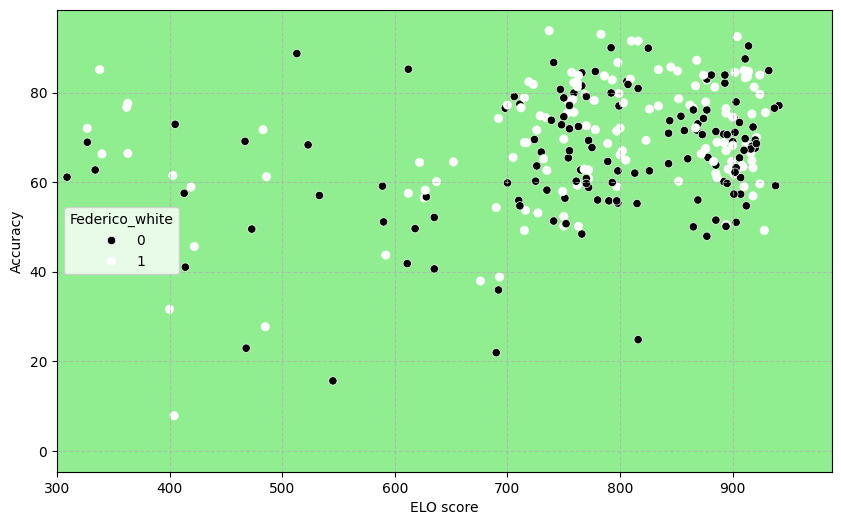

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame for non-null Federico_accuracy values
df_filtered = df.dropna(subset=['Federico_accuracy'])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the background color within the axes
ax.set_facecolor('lightgreen')

# Fill the area between the axes with green color
ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], facecolor='lightgreen', alpha=0.5)
ax.axvspan(300, ax.get_xlim()[1], facecolor='lightgreen', alpha=0.5)

# Create a scatter plot with color-coded dots
sns.scatterplot(x='Federico_ELO', y='Federico_accuracy', hue='Federico_white', palette={0: 'black', 1: 'white'}, data=df_filtered)

# Set labels and title
plt.xlabel('ELO score')
plt.ylabel('Accuracy')


# Set x-axis limits starting from 300
plt.xlim(300, ax.get_xlim()[1])

# Show the legend
plt.legend(title='Federico_white')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


Black Line: Slope = 0.0278, Intercept = 44.0193
White Line: Slope = 0.0300, Intercept = 46.5107


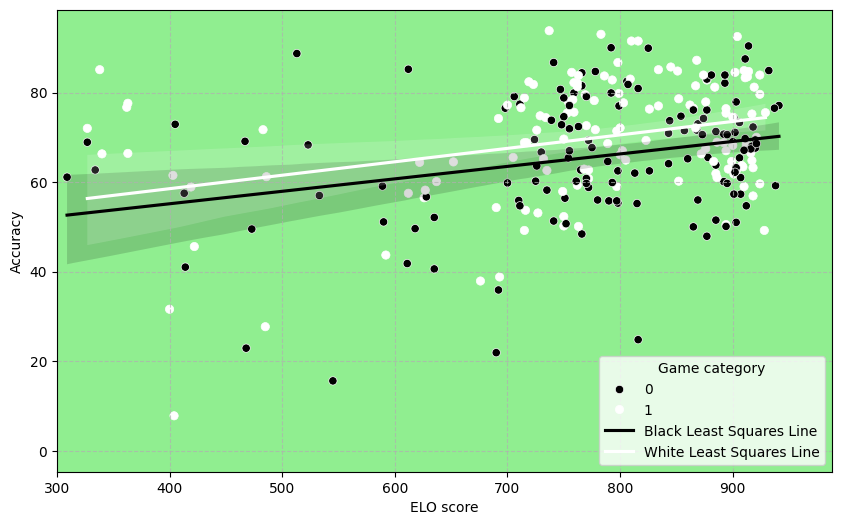

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter the DataFrame for non-null Federico_accuracy values
df_filtered = df.dropna(subset=['Federico_accuracy'])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the background color within the axes
ax.set_facecolor('lightgreen')

# Fill the area between the axes with green color
ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], facecolor='lightgreen', alpha=0.5)
ax.axvspan(300, ax.get_xlim()[1], facecolor='lightgreen', alpha=0.5)

# Create a scatter plot with color-coded dots
scatter_plot = sns.scatterplot(x='Federico_ELO', y='Federico_accuracy', hue='Federico_white', palette={0: 'black', 1: 'white'}, data=df_filtered)

# Add least squares lines for white and black dots
reg_black = sns.regplot(x='Federico_ELO', y='Federico_accuracy', data=df_filtered[df_filtered['Federico_white'] == 0], scatter=False, ax=ax, color='black', label='Black Least Squares Line')
reg_white = sns.regplot(x='Federico_ELO', y='Federico_accuracy', data=df_filtered[df_filtered['Federico_white'] == 1], scatter=False, ax=ax, color='white', label='White Least Squares Line')

# Get the coefficients and intercepts
slope_black, intercept_black = np.polyfit(df_filtered[df_filtered['Federico_white'] == 0]['Federico_ELO'], df_filtered[df_filtered['Federico_white'] == 0]['Federico_accuracy'], 1)
slope_white, intercept_white = np.polyfit(df_filtered[df_filtered['Federico_white'] == 1]['Federico_ELO'], df_filtered[df_filtered['Federico_white'] == 1]['Federico_accuracy'], 1)

# Print the coefficients and intercepts
print(f"Black Line: Slope = {slope_black:.4f}, Intercept = {intercept_black:.4f}")
print(f"White Line: Slope = {slope_white:.4f}, Intercept = {intercept_white:.4f}")

# Set labels and title
plt.xlabel('ELO score')
plt.ylabel('Accuracy')


# Set x-axis limits starting from 300
plt.xlim(300, ax.get_xlim()[1])

# Show the legend
plt.legend(title='Game category')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()



Slope Before Premium: 0.5
Slope After Premium: 0.851


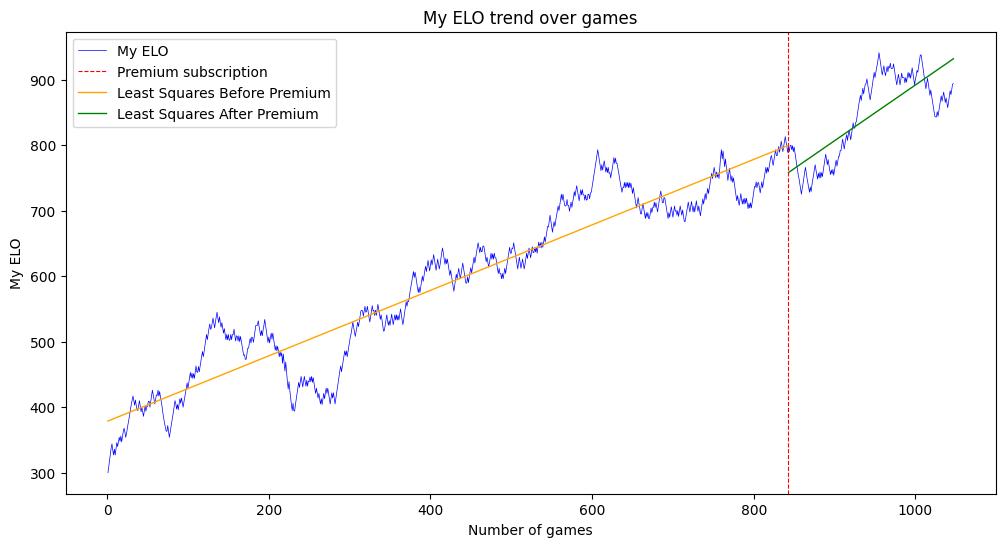

In [229]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse the DataFrame for chronological order
df = df[::-1]

# Define the rank where the premium membership starts
premium_start_rank = rank_dec_8_2023 + 11

# Split the DataFrame into two periods
before_premium = df[df['Rank'] <= premium_start_rank]
after_premium = df[df['Rank'] > premium_start_rank]

# Fit least squares lines for each period
fit_before_premium = np.polyfit(before_premium['Rank'], before_premium['Federico_ELO'], 1)
fit_after_premium = np.polyfit(after_premium['Rank'], after_premium['Federico_ELO'], 1)

# Extract coefficients
slope_before_premium, _ = fit_before_premium
slope_after_premium, _ = fit_after_premium

# Print the coefficients rounded to 3 decimal places
print(f'Slope Before Premium: {round(slope_before_premium, 3)}')
print(f'Slope After Premium: {round(slope_after_premium, 3)}')

# Create a mask for the range of each period
mask_before_premium = df['Rank'] <= premium_start_rank
mask_after_premium = df['Rank'] > premium_start_rank

# Calculate least squares lines for each period
least_squares_line_before = np.polyval(fit_before_premium, df['Rank'][mask_before_premium])
least_squares_line_after = np.polyval(fit_after_premium, df['Rank'][mask_after_premium])

# Plotting the trend of Federico_ELO over games
plt.figure(figsize=(12, 6))
plt.plot(df['Rank'], df['Federico_ELO'], marker='o', linestyle='-', color='blue', linewidth=0.5, markersize=0, label='My ELO')

# Adding a vertical red line at membership
plt.axvline(x=premium_start_rank, color='red', linestyle='--', linewidth=0.8, label='Premium subscription')

# Adding least squares lines for each period
plt.plot(df['Rank'][mask_before_premium], least_squares_line_before, color='orange', linestyle='-', linewidth=1, label='Least Squares Before Premium')
plt.plot(df['Rank'][mask_after_premium], least_squares_line_after, color='green', linestyle='-', linewidth=1, label='Least Squares After Premium')

# Setting labels and title
plt.xlabel('Number of games')
plt.ylabel('My ELO')
plt.title('My ELO trend over games')

# Adding legend
plt.legend()

# Show the plot
plt.show()



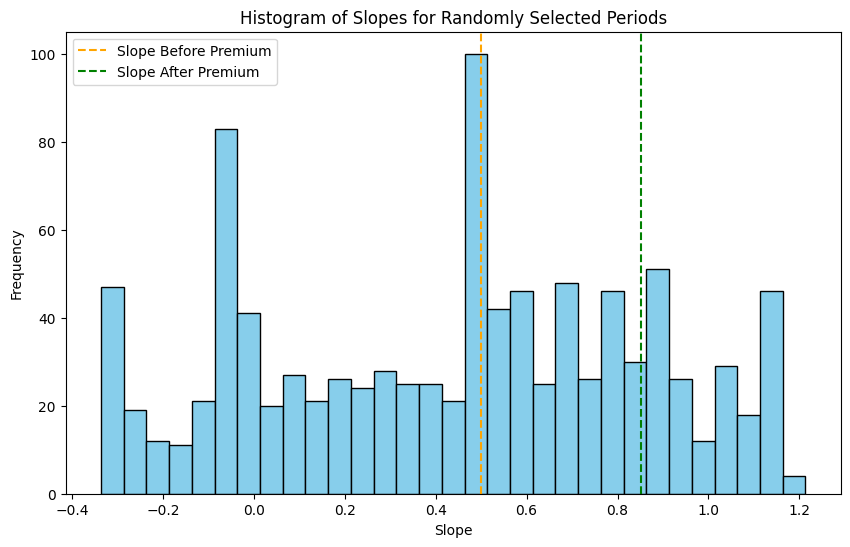

In [230]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the total number of premium games
tot_premium_games = np.max(df['Rank']) - premium_start_rank

# Step 2: Generate random rank values for the beginning of each period
np.random.seed(42)  # Set a seed for reproducibility
random_start_ranks = np.random.randint(1, premium_start_rank - tot_premium_games, size=1000)

# Step 3: Calculate slopes for each randomly selected period
slopes = []
for start_rank in random_start_ranks:
    end_rank = start_rank + tot_premium_games
    period_df = df[(df['Rank'] >= start_rank) & (df['Rank'] <= end_rank)]
    fit_period = np.polyfit(period_df['Rank'], period_df['Federico_ELO'], 1)
    slope, _ = fit_period
    slopes.append(slope)

# Step 4: Plot the histogram of slopes with a specified bin width
plt.figure(figsize=(10, 6))

bin_width = 0.05  # Adjust this value based on your preference
bins = np.arange(min(slopes), max(slopes) + bin_width, bin_width)
plt.hist(slopes, bins=bins, color='skyblue', edgecolor='black')
plt.axvline(x=slope_before_premium, color='orange', linestyle='--', linewidth=1.5, label='Slope Before Premium')
plt.axvline(x=slope_after_premium, color='green', linestyle='--', linewidth=1.5, label='Slope After Premium')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Slopes for Randomly Selected Periods')
plt.legend()
plt.show()

In [244]:
df_white = df[df['Federico_white'] == 1].copy()
df_black = df[df['Federico_white'] == 0].copy()

# Get the minimum length between the two DataFrames
min_length = min(len(df_white), len(df_black))

# Slice both DataFrames to the minimum length
df_white = df_white.iloc[:min_length].copy()
df_black = df_black.iloc[:min_length].copy()

# Create the New_Rank variable for both DataFrames
df_white['New_rank'] = range(len(df_white), 0, -1)
df_black['New_rank'] = range(len(df_black), 0, -1)

df_white = df_white.sort_values(by='New_rank')
df_black = df_black.sort_values(by='New_rank')

# Add Federico_Result to both DataFrames
df_white['Cumulative_score_white'] = df_white['Federico_result'].cumsum() - df_white['New_rank'].min() + 1
df_black['Cumulative_score_black'] = df_black['Federico_result'].cumsum() - df_black['New_rank'].min() + 1

print(df_white[['New_rank', 'Cumulative_score_white', 'Federico_result', 'Federico_ELO']].head())

print(df_black[['New_rank', 'Cumulative_score_black', 'Federico_result', 'Federico_ELO']].head())



      New_rank  Cumulative_score_white  Federico_result  Federico_ELO
1044         1                     1.0              1.0           319
1042         2                     2.0              1.0           338
1041         3                     3.0              1.0           344
1039         4                     3.0              0.0           327
1038         5                     4.0              1.0           336
      New_rank  Cumulative_score_black  Federico_result  Federico_ELO
1045         1                     1.0              1.0           309
1043         2                     2.0              1.0           328
1040         3                     2.0              0.0           334
1037         4                     2.0              0.0           327
1036         5                     3.0              1.0           337


In [232]:
import pandas as pd

# Assuming you have df_white and df_black from the previous code

# Merge New_rank and Cumulative_score from df_white and df_black
comparison_df = pd.merge(df_white[['New_rank', 'Cumulative_score_white', 'Federico_result', 'Federico_ELO']],
                          df_black[['New_rank', 'Cumulative_score_black', 'Federico_result', 'Federico_ELO']],
                          on='New_rank', how='outer')

# Display the resulting DataFrame
comparison_df.head(5)

,New_rank,Cumulative_score_white,Federico_result_x,Federico_ELO_x,Cumulative_score_black,Federico_result_y,Federico_ELO_y
0,1,1.0,1.0,319,1.0,1.0,309
1,2,2.0,1.0,338,2.0,1.0,328
2,3,3.0,1.0,344,2.0,0.0,334
3,4,3.0,0.0,327,2.0,0.0,327
4,5,4.0,1.0,336,3.0,1.0,337


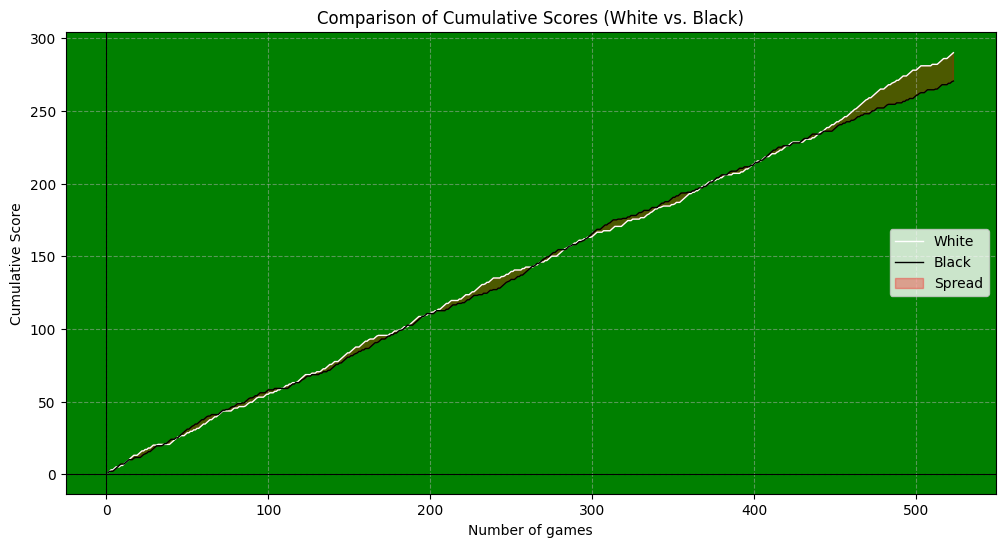

In [233]:
import matplotlib.pyplot as plt

# Plotting the lines for Cumulative_score_white and Cumulative_score_black
plt.figure(figsize=(12, 6))

# Set the background color to green
plt.gca().set_facecolor('green')

plt.plot(comparison_df['New_rank'], comparison_df['Cumulative_score_white'], label='White', color='white', linewidth=1)
plt.plot(comparison_df['New_rank'], comparison_df['Cumulative_score_black'], label='Black', color='black', linewidth=1)

# Highlight the spread between the two lines
plt.fill_between(comparison_df['New_rank'], comparison_df['Cumulative_score_white'], comparison_df['Cumulative_score_black'],
                 where=(comparison_df['Cumulative_score_white'] != comparison_df['Cumulative_score_black']),
                 interpolate=True, color='red', alpha=0.3, label='Spread')

# Set the intersection of the x and y axes to 0
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Setting labels and title
plt.xlabel('Number of games')
plt.ylabel('Cumulative Score')
plt.title('Comparison of Cumulative Scores (White vs. Black)')

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [234]:
# Filter df_white for the date '8th Dec 2023'
df_white_dec_8_2023 = df_white[df_white['Date'] == '8th Dec 2023']

# Print the 'New_rank' column for df_white on 8th Dec 2023
print(df_white_dec_8_2023[['New_rank']])

     New_rank
215       417
214       418


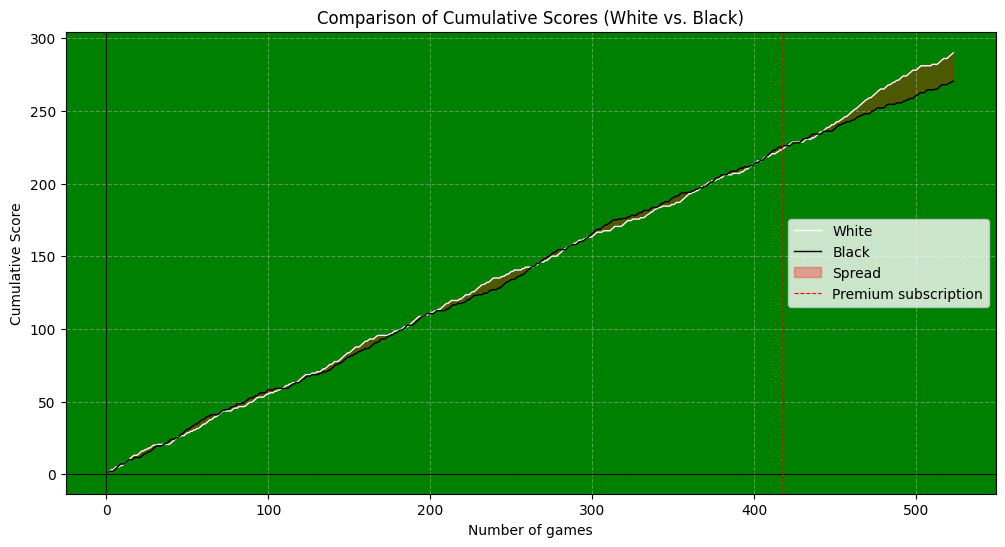

In [235]:
import matplotlib.pyplot as plt

# Plotting the lines for Cumulative_score_white and Cumulative_score_black
plt.figure(figsize=(12, 6))

# Set the background color to green
plt.gca().set_facecolor('green')

plt.plot(comparison_df['New_rank'], comparison_df['Cumulative_score_white'], label='White', color='white', linewidth=1)
plt.plot(comparison_df['New_rank'], comparison_df['Cumulative_score_black'], label='Black', color='black', linewidth=1)

# Highlight the spread between the two lines
plt.fill_between(comparison_df['New_rank'], comparison_df['Cumulative_score_white'], comparison_df['Cumulative_score_black'],
                 where=(comparison_df['Cumulative_score_white'] != comparison_df['Cumulative_score_black']),
                 interpolate=True, color='red', alpha=0.3, label='Spread')

# Set the intersection of the x and y axes to 0
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Adding a vertical red line at membership
plt.axvline(x=417, color='red', linestyle='--', linewidth=0.8, label='Premium subscription')

# Setting labels and title
plt.xlabel('Number of games')
plt.ylabel('Cumulative Score')
plt.title('Comparison of Cumulative Scores (White vs. Black)')

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [236]:
# Assuming 'New_rank' is the column representing the rank
zoom_df = comparison_df[comparison_df['New_rank'] > 417].copy()
zoom_df['New_rank'] = zoom_df['New_rank'] - 417

columns_to_drop = [
    'Cumulative_score_white',
    'Cumulative_score_black'
]
    
zoom_df = zoom_df.drop(columns=columns_to_drop)

zoom_df['Cumulative_score_white'] = zoom_df['Federico_result_x'].cumsum() - zoom_df['New_rank'].min() + 1
zoom_df['Cumulative_score_black'] = zoom_df['Federico_result_y'].cumsum() - zoom_df['New_rank'].min() + 1

zoom_df.head(5)

,New_rank,Federico_result_x,Federico_ELO_x,Federico_result_y,Federico_ELO_y,Cumulative_score_white,Cumulative_score_black
417,1,1.0,797,1.0,813,1.0,1.0
418,2,1.0,798,0.0,805,2.0,1.0
419,3,1.0,805,0.0,789,3.0,1.0
420,4,0.0,798,0.0,790,3.0,1.0
421,5,1.0,797,0.0,793,4.0,1.0


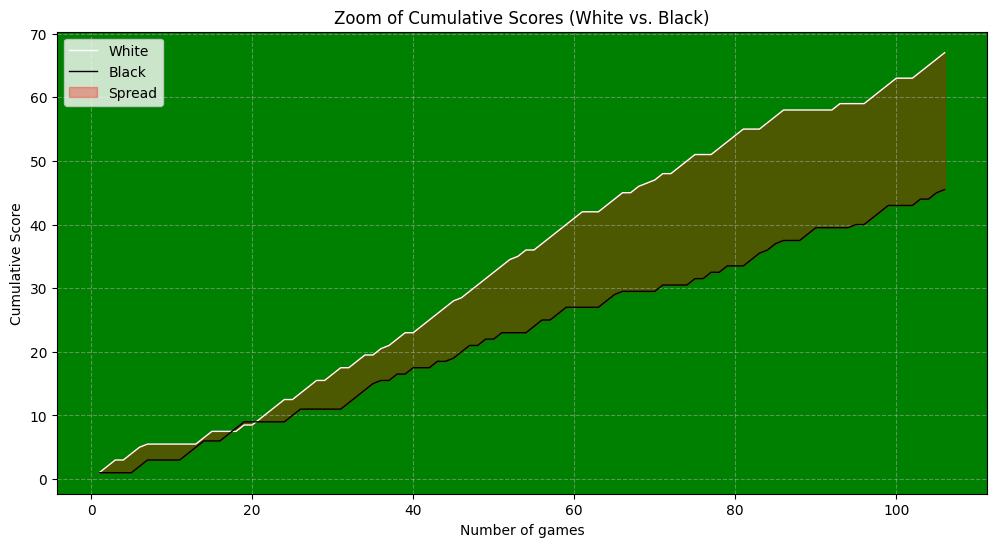

In [237]:
import matplotlib.pyplot as plt

# Plotting the lines for Cumulative_score_white and Cumulative_score_black
plt.figure(figsize=(12, 6))

# Set the background color to green
plt.gca().set_facecolor('green')

plt.plot(zoom_df['New_rank'], zoom_df['Cumulative_score_white'], label='White', color='white', linewidth=1)
plt.plot(zoom_df['New_rank'], zoom_df['Cumulative_score_black'], label='Black', color='black', linewidth=1)

# Highlight the spread between the two lines
plt.fill_between(zoom_df['New_rank'], zoom_df['Cumulative_score_white'], zoom_df['Cumulative_score_black'],
                 where=(zoom_df['Cumulative_score_white'] != zoom_df['Cumulative_score_black']),
                 interpolate=True, color='red', alpha=0.3, label='Spread')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)


# Setting labels and title
plt.xlabel('Number of games')
plt.ylabel('Cumulative Score')
plt.title('Zoom of Cumulative Scores (White vs. Black)')

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [238]:
import pandas as pd

# Count the total number of games for both white and black
total_games_white = len(df_white)
total_games_black = len(df_black)

# Count the number of wins, losses, and draws for both white and black
wins_white = len(df_white[df_white['Federico_result'] == 1])
losses_white = len(df_white[df_white['Federico_result'] == 0])
draws_white = len(df_white[df_white['Federico_result'] == 0.5])

wins_black = len(df_black[df_black['Federico_result'] == 1])
losses_black = len(df_black[df_black['Federico_result'] == 0])
draws_black = len(df_black[df_black['Federico_result'] == 0.5])

# Create a DataFrame for the contingency table
contingency_table = pd.DataFrame({
    'Wins': [wins_white, wins_black],
    'Losses': [losses_white, losses_black],
    'Draws': [draws_white, draws_black],
    'Total': [total_games_white, total_games_black]
}, index=['White', 'Black'])

# Calculate percentages
contingency_table_percentages = (contingency_table.div(contingency_table['Total'], axis=0) * 100).round(2)

# Print the contingency table
print("Contingency Table - Counts:")
print(contingency_table)
print("\nContingency Table - Percentages:")
print(contingency_table_percentages)
print(f'\nWhite W/L Ratio: {round(wins_white/losses_white, 2)}')
print(f'Black W/L Ratio: {round(wins_black/losses_black, 2)}')

Contingency Table - Counts:
       Wins  Losses  Draws  Total
White   277     220     26    523
Black   250     232     41    523

Contingency Table - Percentages:
        Wins  Losses  Draws  Total
White  52.96   42.07   4.97  100.0
Black  47.80   44.36   7.84  100.0

White W/L Ratio: 1.26
Black W/L Ratio: 1.08


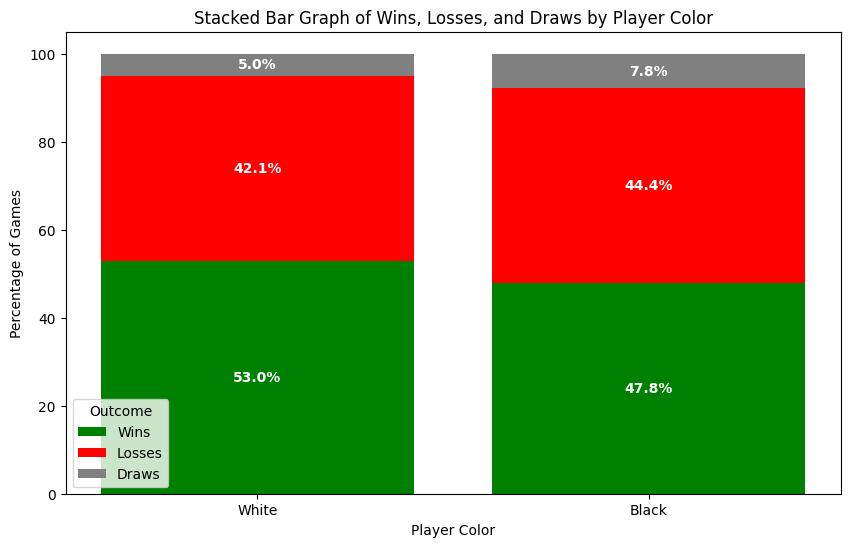

In [239]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the stacked bar graph
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar graph for white and black
bars = np.array([contingency_table_percentages['Wins'], contingency_table_percentages['Losses'], contingency_table_percentages['Draws']])
colors = ['green', 'red', 'grey']

# Calculate the bottom values for the bars
bottoms = np.zeros(len(contingency_table_percentages))
for i, (colname, color) in enumerate(zip(contingency_table_percentages.columns[:-1], colors)):
    ax.bar(contingency_table_percentages.index, bars[i], bottom=bottoms, label=colname, color=color)
    bottoms += bars[i]

# Add data labels
for i, bar in enumerate(bars):
    for j, val in enumerate(bar):
        ax.text(j, np.sum(bars[:i], axis=0)[j] + val / 2, f'{val:.1f}%', ha='center', va='center', color='white', fontweight='bold')

# Setting labels and title
ax.set_xlabel('Player Color')
ax.set_ylabel('Percentage of Games')
ax.set_title('Stacked Bar Graph of Wins, Losses, and Draws by Player Color')

# Adding legend
ax.legend(title='Outcome')

# Show the plot
plt.show()


Average Ratio for White Games (Bootstrap): 0.5283
Average Ratio for Black Games (Bootstrap): 0.4784


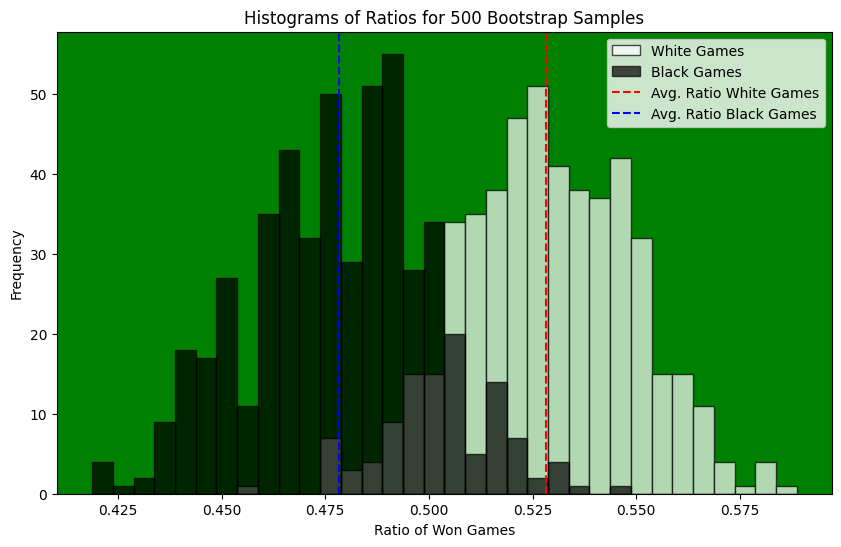

In [241]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have separate DataFrames for white and black games
df_white = df[df['Federico_white'] == 1]
df_black = df[df['Federico_white'] == 0]

# Number of bootstrap samples
num_bootstrap_samples = 500

# Create arrays to store the ratios for white and black games
ratios_white_bootstrap = []
ratios_black_bootstrap = []

# Bootstrap for white games
for _ in range(num_bootstrap_samples):
    # Bootstrap sample
    bootstrap_sample_white = np.random.choice(df_white['Federico_result'], size=len(df_white), replace=True)
    
    # Calculate the ratio of won games for white games
    ratio_won_games_white = np.sum(bootstrap_sample_white == 1) / len(bootstrap_sample_white)
    
    # Append the ratio to the list for white games
    ratios_white_bootstrap.append(ratio_won_games_white)

# Bootstrap for black games
for _ in range(num_bootstrap_samples):
    # Bootstrap sample
    bootstrap_sample_black = np.random.choice(df_black['Federico_result'], size=len(df_black), replace=True)
    
    # Calculate the ratio of won games for black games
    ratio_won_games_black = np.sum(bootstrap_sample_black == 1) / len(bootstrap_sample_black)
    
    # Append the ratio to the list for black games
    ratios_black_bootstrap.append(ratio_won_games_black)

# Calculate average ratios
avg_ratio_white_bootstrap = np.mean(ratios_white_bootstrap)
avg_ratio_black_bootstrap = np.mean(ratios_black_bootstrap)

print(f'Average Ratio for White Games (Bootstrap): {avg_ratio_white_bootstrap:.4f}')
print(f'Average Ratio for Black Games (Bootstrap): {avg_ratio_black_bootstrap:.4f}')

# Get the range of the distributions for setting x-axis limits
min_value = min(np.min(ratios_white_bootstrap), np.min(ratios_black_bootstrap))
max_value = max(np.max(ratios_white_bootstrap), np.max(ratios_black_bootstrap))

# Step 3: Plot the histograms on a green background with vertical lines for averages
plt.figure(figsize=(10, 6))  # Adjust the figure width based on the range of values

# Manually adjust bin size (here set to 0.02)
bin_size = 0.005

plt.hist(ratios_white_bootstrap, bins=np.arange(min_value, max_value + bin_size, bin_size), color='white', edgecolor='black', alpha=0.7, label='White Games')
plt.hist(ratios_black_bootstrap, bins=np.arange(min_value, max_value + bin_size, bin_size), color='black', edgecolor='black', alpha=0.7, label='Black Games')

# Plot vertical lines for averages
plt.axvline(x=avg_ratio_white_bootstrap, color='red', linestyle='--', linewidth=1.5, label='Avg. Ratio White Games')
plt.axvline(x=avg_ratio_black_bootstrap, color='blue', linestyle='--', linewidth=1.5, label='Avg. Ratio Black Games')

plt.xlabel('Ratio of Won Games')
plt.ylabel('Frequency')
plt.title(f'Histograms of Ratios for {num_bootstrap_samples} Bootstrap Samples')
plt.legend()

# Set the background color to green
plt.gca().set_facecolor('green')

plt.show()



In [242]:
# Calculate the number of ratios from the black simulation that are greater than the average white ratio
count_greater_than_avg_white = np.sum(np.array(ratios_black_bootstrap) > avg_ratio_white_bootstrap)

# Calculate the percentage
percentage_greater_than_avg_white = (count_greater_than_avg_white / num_bootstrap_samples) * 100

print(f'Percentage of Ratios from Black Simulation Bigger than Average White Ratio: {percentage_greater_than_avg_white:.2f}%')


Percentage of Ratios from Black Simulation Bigger than Average White Ratio: 1.20%


In [245]:
import pandas as pd

# Assuming df is the original DataFrame containing the relevant data

# Separate premium and non-premium games for both white and black
df_white_premium = df_white[df_white['New_rank'] > 417].copy()
df_white_non_premium = df_white[df_white['New_rank'] <= 417].copy()

df_black_premium = df_black[df_black['New_rank'] > 417].copy()
df_black_non_premium = df_black[df_black['New_rank'] <= 417].copy()

# Create a function to calculate counts and percentages for each group
def calculate_contingency_table(df_group, group_name):
    # Count the total number of games
    total_games = len(df_group)

    # Count the number of wins, losses, and draws
    wins = len(df_group[df_group['Federico_result'] == 1])
    losses = len(df_group[df_group['Federico_result'] == 0])
    draws = len(df_group[df_group['Federico_result'] == 0.5])

    # Create a DataFrame for the contingency table
    contingency_table_counts = pd.DataFrame({
        'Wins': [wins],
        'Losses': [losses],
        'Draws': [draws],
        'Total': [total_games]
    }, index=[f'{group_name} Count'])

    # Calculate percentages
    contingency_table_percentages = (contingency_table_counts.div(contingency_table_counts['Total'], axis=0) * 100).round(2)
    contingency_table_percentages.index = [f'{group_name} Percentage']

    return contingency_table_counts, contingency_table_percentages

# Calculate contingency tables for each group
contingency_table_black_non_premium_counts, contingency_table_black_non_premium_percentages = calculate_contingency_table(df_black_non_premium, 'Black Non-Premium')
contingency_table_white_non_premium_counts, contingency_table_white_non_premium_percentages = calculate_contingency_table(df_white_non_premium, 'White Non-Premium')

contingency_table_white_premium_counts, contingency_table_white_premium_percentages = calculate_contingency_table(df_white_premium, 'White Premium')
contingency_table_black_premium_counts, contingency_table_black_premium_percentages = calculate_contingency_table(df_black_premium, 'Black Premium')


# Concatenate DataFrames for the overall contingency tables
contingency_table_overall_counts = pd.concat([
    contingency_table_white_premium_counts,
    contingency_table_white_non_premium_counts,
    contingency_table_black_premium_counts,
    contingency_table_black_non_premium_counts
])

contingency_table_overall_percentages = pd.concat([
    contingency_table_white_premium_percentages,
    contingency_table_white_non_premium_percentages,
    contingency_table_black_premium_percentages,
    contingency_table_black_non_premium_percentages
])

# Print the contingency tables
print("\nContingency Table - Counts:")
print(contingency_table_white_premium_counts)
print(contingency_table_black_premium_counts)
print("\n")
print(contingency_table_white_non_premium_counts)
print(contingency_table_black_non_premium_counts)

print("\nContingency Table - Percentages:")
print(contingency_table_white_premium_percentages)
print(contingency_table_black_premium_percentages)
print("\n")
print(contingency_table_white_non_premium_percentages)
print(contingency_table_black_non_premium_percentages)





Contingency Table - Counts:
                     Wins  Losses  Draws  Total
White Premium Count    64      36      6    106
                     Wins  Losses  Draws  Total
Black Premium Count    42      57      7    106


                         Wins  Losses  Draws  Total
White Non-Premium Count   213     184     20    417
                         Wins  Losses  Draws  Total
Black Non-Premium Count   208     175     34    417

Contingency Table - Percentages:
                           Wins  Losses  Draws  Total
White Premium Percentage  60.38   33.96   5.66  100.0
                           Wins  Losses  Draws  Total
Black Premium Percentage  39.62   53.77    6.6  100.0


                               Wins  Losses  Draws  Total
White Non-Premium Percentage  51.08   44.12    4.8  100.0
                               Wins  Losses  Draws  Total
Black Non-Premium Percentage  49.88   41.97   8.15  100.0


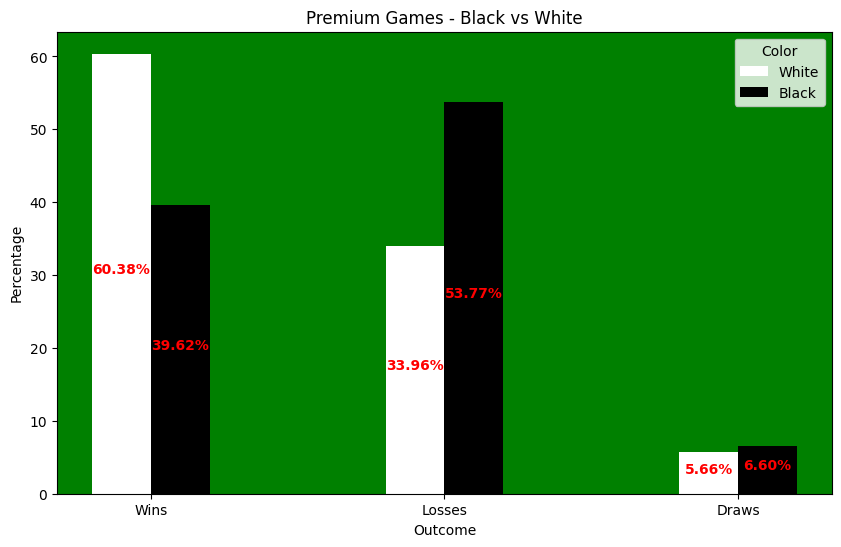

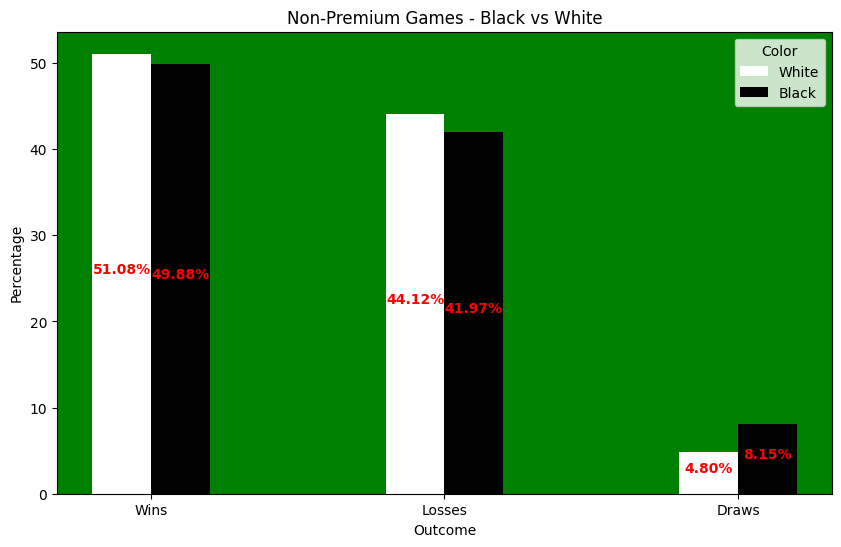

In [246]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a stacked bar graph
def plot_stacked_bars(data, title, categories):
    labels = ['Wins', 'Losses', 'Draws']
    colors = ['white', 'black']

    # Plotting the stacked bar graph
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the background color
    plt.gca().set_facecolor('green')

    # Plotting for each category
    for i in range(len(data)):
        bars = ax.bar(np.arange(len(labels)) + 0.2 * i, data[i], width=0.2, label=f'{categories[i]}', color=colors[i])

        # Adding data labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords='offset points',
                        ha='center', va='center', color='red', fontweight='bold')

    # Setting labels and title
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)) + 0.2 * (len(categories) - 1) / 2)
    ax.set_xticklabels(labels)

    # Adding legend
    ax.legend(title='Color')

    # Show the plot
    plt.show()

# Plotting for Premium Games
plot_stacked_bars([contingency_table_white_premium_percentages.iloc[0, :3].values,
                   contingency_table_black_premium_percentages.iloc[0, :3].values],
                  'Premium Games - Black vs White', ['White', 'Black'])

# Plotting for Non-Premium Games
plot_stacked_bars([contingency_table_white_non_premium_percentages.iloc[0, :3].values,
                   contingency_table_black_non_premium_percentages.iloc[0, :3].values],
                  'Non-Premium Games - Black vs White', ['White', 'Black'])
